## Proyecto de identificación de tópicos en texto (Procesamiento del Lenguaje Natural - topic modeling con Gensim)

El topic modeling es una técnica no supervisada de NLP, capaz de detectar y extraer de manera automática relaciones semánticas latentes de grandes volúmenes de información.

Estas relaciones son los llamados tópicos, que son un conjunto de palabras que suelen aparecer juntas en los mismos contextos y nos permiten observar relaciones que seríamos incapaces de observar a simple vista.

Existen diversas técnicas que pueden ser usadas para obtener estos tópicos. El principal algoritmo y que además será el que utilizaremos en esta publicación, es el modelo **"Latent Dirichlet Allocation" (LDA)**, propuesto por David Blei en 2011, que nos devuelve por un lado los diferentes tópicos que componen la colección de documentos y por otro lado cuánto de cada tópico está presente en cada documento.

In [8]:
# Importamos las librerías que utilizaremos
import json, re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import ToktokTokenizer

In [2]:
#Importamos el archivo txt con las noticias que vamos a analizar
from google.colab import files
uploaded = files.upload()

Saving noticias.txt to noticias.txt


In [3]:
with open('noticias.txt') as json_file:
    datos = json.load(json_file)
tuplas = list(zip([noticia.get("titular") for noticia in datos],
                  [noticia.get("texto") for noticia in datos]))
df = pd.DataFrame(tuplas, columns =['Titular', 'Noticia'])
print(df.shape)
df.head()

(5665, 2)


,Titular,Noticia
0,Un estudio impulsado por la Universidad de San...,El virus SARS-Cov-2 entró en España por la ciu...
1,Las claves: qué es Montai y quién está detrás,¿Qué es Montai? ¿Qué relación guarda con las o...
2,Robots entregan domicilios en Medellín durante...,Unos 15 robots recorren las calles de Medellín...
3,Grazón insiste en que un nuevo estado de alarm...,"En una entrevista en Radio Euskadi, recogida p..."
4,Vox se sube a la ola de la extrema derecha eur...,"""España ha dejado de ser católica"", decía Manu..."


In [18]:
# Eliminamos los caracteres especiales como ¿ o ¡, las palabras con un solo carácter que normalmente no contienen 
# información útil y convertimos todo a minúsculas entre otras tareas.
# En el siguiente código implementamos un método que se encarga de realizar esta limpieza inicial de los textos
def limpiar_texto(texto):
    """
    Función para realizar la limpieza de un texto dado.
    """
    # Eliminamos los caracteres especiales
    texto = re.sub(r'\W', ' ', str(texto))
    # Eliminado las palabras que tengo un solo caracter
    texto = re.sub(r'\s+[a-zA-Z]\s+', ' ', texto)
    # Sustituir los espacios en blanco en uno solo
    texto = re.sub(r'\s+', ' ', texto, flags=re.I)
    # Convertimos textos a minusculas
    texto = texto.lower()

    #texto = texto.split()
    return texto


In [19]:
# Seguidamente aplicamos la función a cada noticia contenida en nuestro objeto y mostramos de nuevo las 5 primeras

In [20]:
df["Tokens"] = df.Noticia.apply(limpiar_texto)
df.head()

,Titular,Noticia,Tokens
0,Un estudio impulsado por la Universidad de San...,El virus SARS-Cov-2 entró en España por la ciu...,el virus sars cov 2 entró en españa por la ciu...
1,Las claves: qué es Montai y quién está detrás,¿Qué es Montai? ¿Qué relación guarda con las o...,qué es montai qué relación guarda con las otr...
2,Robots entregan domicilios en Medellín durante...,Unos 15 robots recorren las calles de Medellín...,unos 15 robots recorren las calles de medellín...
3,Grazón insiste en que un nuevo estado de alarm...,"En una entrevista en Radio Euskadi, recogida p...",en una entrevista en radio euskadi recogida po...
4,Vox se sube a la ola de la extrema derecha eur...,"""España ha dejado de ser católica"", decía Manu...",españa ha dejado de ser católica decía manuel...


In [21]:
# Luego llega el turno del proceso de tokenización, que consiste en dividir los textos en tokens o palabras individuales. 
# Para ello, la librería  NLTK nos proporciona el objeto ToktokTokenizer con la función tokenize() para tokenizar nuestros textos.
tokenizer = ToktokTokenizer() 
df["Tokens"] = df.Tokens.apply(tokenizer.tokenize)
df.head()

,Titular,Noticia,Tokens
0,Un estudio impulsado por la Universidad de San...,El virus SARS-Cov-2 entró en España por la ciu...,"[el, virus, sars, cov, 2, entró, en, españa, p..."
1,Las claves: qué es Montai y quién está detrás,¿Qué es Montai? ¿Qué relación guarda con las o...,"[qué, es, montai, qué, relación, guarda, con, ..."
2,Robots entregan domicilios en Medellín durante...,Unos 15 robots recorren las calles de Medellín...,"[unos, 15, robots, recorren, las, calles, de, ..."
3,Grazón insiste en que un nuevo estado de alarm...,"En una entrevista en Radio Euskadi, recogida p...","[en, una, entrevista, en, radio, euskadi, reco..."
4,Vox se sube a la ola de la extrema derecha eur...,"""España ha dejado de ser católica"", decía Manu...","[españa, ha, dejado, de, ser, católica, decía,..."


###  A continuación, eliminamos las stopwords que componen los textos, es decir, las palabras comunes que no aportan significado. Previamente debemos descargar la lista de stopwords en castellano mediante el comando stopwords.words("spanish").

In [22]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
# En el siguiente código vemos como construir y aplicar a nuestros datos una función para filtrar fuera de los textos las stopwords y los dígitos

STOPWORDS = set(stopwords.words("spanish"))

def filtrar_stopword_digitos(tokens):
    """
    Filtra stopwords y digitos de una lista de tokens.
    """
    return [token for token in tokens if token not in STOPWORDS 
            and not token.isdigit()]

df["Tokens"] = df.Tokens.apply(filtrar_stopword_digitos)
df.head()

,Titular,Noticia,Tokens
0,Un estudio impulsado por la Universidad de San...,El virus SARS-Cov-2 entró en España por la ciu...,"[virus, sars, cov, entró, españa, ciudad, vito..."
1,Las claves: qué es Montai y quién está detrás,¿Qué es Montai? ¿Qué relación guarda con las o...,"[montai, relación, guarda, empresas, quién, de..."
2,Robots entregan domicilios en Medellín durante...,Unos 15 robots recorren las calles de Medellín...,"[robots, recorren, calles, medellín, realizar,..."
3,Grazón insiste en que un nuevo estado de alarm...,"En una entrevista en Radio Euskadi, recogida p...","[entrevista, radio, euskadi, recogida, europa,..."
4,Vox se sube a la ola de la extrema derecha eur...,"""España ha dejado de ser católica"", decía Manu...","[españa, dejado, ser, católica, decía, manuel,..."


En la esta fase final reducimos cada palabra a su raíz mediante el proceso de stemming. Por ejemplo, este algoritmo reduciría las palabras escribir, escribiendo y escribió a escrib. Para este ejemplo usaré el algoritmo de Porter incluido en la librería NLTK y compatible con el idioma castellano. Para utilizarlo, simplemente creamos un objeto SnowballStemmer y usamos la función stem() como podemos ver en el siguiente código.

In [24]:
stemmer = SnowballStemmer("spanish")

def stem_palabras(tokens):
    """
    Reduce cada palabra de una lista dada a su raíz.
    """
    return [stemmer.stem(token) for token in tokens]

df["Tokens"] = df.Tokens.apply(stem_palabras)

df.head()

,Titular,Noticia,Tokens
0,Un estudio impulsado por la Universidad de San...,El virus SARS-Cov-2 entró en España por la ciu...,"[virus, sars, cov, entro, españ, ciud, vitori,..."
1,Las claves: qué es Montai y quién está detrás,¿Qué es Montai? ¿Qué relación guarda con las o...,"[montai, relacion, guard, empres, quien, detra..."
2,Robots entregan domicilios en Medellín durante...,Unos 15 robots recorren las calles de Medellín...,"[robots, recorr, call, medellin, realiz, entre..."
3,Grazón insiste en que un nuevo estado de alarm...,"En una entrevista en Radio Euskadi, recogida p...","[entrev, radi, euskadi, recog, europ, press, g..."
4,Vox se sube a la ola de la extrema derecha eur...,"""España ha dejado de ser católica"", decía Manu...","[españ, dej, ser, catol, dec, manuel, azañ, co..."


A continuación mostramos las primeras diez palabras procesadas de una noticia de nuestra colección a modo de ejemplo

In [25]:
print(df.Tokens[0][0:10])

['virus', 'sars', 'cov', 'entro', 'españ', 'ciud', 'vitori', 'torn', 'febrer', 'conclusion']


Vamos a construir un diccionario con todas las palabras y un corpus con la frecuencia de las palabras en cada documento. Así, estos dos serán las principales entradas de nuestro modelo LDA. Veamos en primer lugar cómo podemos obtenerlos.

In [26]:
# Generación del diccionario y corpus, principales entradas del modelo LDA
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import random
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

In [27]:
# Creamos un diccionario con nuestra lista de palabras almacenadas en df.Tokens
diccionario = Dictionary(df.Tokens)
print(f'Número de tokens: {len(diccionario)}')

Número de tokens: 47388


Después, reducimos el diccionario filtrando las palabras más raras o demasiado frecuentes. Para ello haremos uso de la función filter_extremes, que nos proporciona el objeto Dictionary y que nos servirá para mantener únicamente aquellos tokens que se encuentran en al menos 2 documentos (no_below) y los que están contenidos en no más del 80% de documentos (no_above).

In [28]:
diccionario.filter_extremes(no_below=2, no_above = 0.8)
print(f'Número de tokens: {len(diccionario)}')

Número de tokens: 25522


Luego, inicializamos el corpus en base al diccionario que acabamos de crear. Cada documento se transformará en una bolsa de palabras (BOW del inglés bag-of-words) con las frecuencias de aparición.

Tras aplicar esta técnica veremos que cada documento está representado como una lista de tuplas donde el primer elemento es el identificador numérico de la palabra y el segundo es el número de veces que esa palabra aparece en el documento.

A continuación se muestra como construimos el corpus aplicando la función doc2bow del diccionario a cada lista de palabras:

In [29]:
# Creamos el corpus 
corpus = [diccionario.doc2bow(noticia) for noticia in df.Tokens]

# Mostramos el BOW de una noticia
print(corpus[6])

[(3, 1), (25, 1), (26, 6), (29, 1), (40, 1), (41, 3), (44, 1), (48, 7), (52, 2), (67, 1), (68, 1), (77, 1), (86, 1), (94, 1), (96, 1), (108, 4), (116, 1), (118, 1), (121, 1), (131, 2), (146, 2), (149, 2), (164, 1), (172, 1), (176, 2), (178, 1), (193, 1), (204, 1), (210, 1), (222, 1), (235, 3), (236, 4), (238, 1), (245, 1), (268, 1), (276, 1), (283, 1), (295, 1), (299, 1), (311, 3), (312, 2), (339, 1), (349, 1), (367, 11), (372, 1), (394, 12), (407, 1), (413, 1), (431, 1), (436, 2), (439, 1), (440, 1), (450, 1), (454, 2), (462, 2), (475, 3), (478, 2), (492, 1), (498, 1), (502, 2), (513, 2), (525, 1), (531, 3), (549, 1), (561, 1), (574, 1), (587, 2), (615, 1), (631, 1), (640, 1), (650, 3), (653, 2), (656, 1), (660, 1), (677, 1), (680, 1), (683, 1), (684, 1), (686, 2), (694, 1), (732, 1), (784, 2), (793, 2), (794, 1), (804, 2), (817, 3), (830, 1), (839, 1), (840, 1), (842, 1), (852, 1), (866, 2), (913, 1), (915, 1), (917, 2), (921, 2), (933, 1), (958, 1), (1055, 1), (1057, 1), (1060, 1), 

En el resultado se muestra la representación BOW de una noticia cualquiera (print(corpus[6])) en la que los primeros 5 elementos son: [(3, 1), (25, 1), (26, 6), (29, 1), (40, 1) …].
Así, la primera tupla (3, 1) indica que, para el primer documento, la palabra con el identificador 3 aparece una vez. Mediante el comando (diccionario[3]) se puede ver que el identificador 3 corresponde al token afirm.

## Construyendo el modelo LDA

Para construir el modelo LDA simplemente creamos un objeto LdaModel de la librería Gensim pasándole como argumento el corpus y el diccionario y le indicamos adicionalmente los siguientes parámetros:

*   num_topics: número de tópicos. Para este tutorial extraeremos 50 tópicos.
*   random_state: parámetro para controlar la aleatoriedad del proceso de entrenamiento y que nos devuelva siempre los mismos resultados.
*   chunksize: número de documentos que será utilizado en cada pasada de entrenamiento.
*   passes: número de pasadas por el corpus durante el entrenamiento.
*   alpha: representa la densidad de tópicos por documento. Un mayor valor de este parámetro implica que los documentos estén compuestos de más tópicos. En este caso, fijamos el valor en auto.


In [30]:
diccionario[3]

'afirm'

In [31]:
lda = LdaModel(corpus=corpus, id2word=diccionario, 
               num_topics=50, random_state=42, 
               chunksize=1000, passes=10, alpha='auto')

In [33]:
# Para visualizar los tópicos extraídos podemos utilizar la función print_topics indicándole el número de tópicos y el número de palabras por tópico que queremos que se muestre
topicos = lda.print_topics(num_words=5, num_topics=20)
for topico in topicos:
    print(topico)

(32, '0.039*"azul" + 0.036*"luz" + 0.031*"velasc" + 0.029*"sueñ" + 0.021*"eloy"')
(10, '0.025*"respir" + 0.025*"bail" + 0.024*"perr" + 0.021*"jon" + 0.018*"street"')
(34, '0.108*"cantabri" + 0.077*"santand" + 0.044*"cantabr" + 0.025*"miguel" + 0.020*"mar"')
(29, '0.048*"dependent" + 0.026*"punic" + 0.025*"servici" + 0.024*"enfermer" + 0.021*"list"')
(20, '0.057*"israel" + 0.030*"palestin" + 0.020*"brasil" + 0.016*"bolsonar" + 0.015*"trump"')
(38, '0.166*"galici" + 0.092*"galleg" + 0.080*"feijo" + 0.072*"xunt" + 0.033*"nuñez"')
(24, '0.023*"efect" + 0.021*"incendi" + 0.014*"estres" + 0.014*"estudi" + 0.012*"quem"')
(9, '0.036*"miguel" + 0.023*"cas" + 0.015*"conden" + 0.012*"pnv" + 0.011*"corrupcion"')
(3, '0.044*"valencian" + 0.025*"per" + 0.018*"valenci" + 0.016*"cuenc" + 0.015*"valènci"')
(4, '0.035*"cas" + 0.030*"univers" + 0.026*"mast" + 0.019*"cifuent" + 0.014*"curs"')
(26, '0.031*"millon" + 0.023*"eur" + 0.019*"econom" + 0.014*"año" + 0.009*"banc"')
(31, '0.044*"trabaj" + 0.016*"e

Por cada tópico podemos ver las cinco palabras que más contribuyen a ese tópico y sus pesos en el mismo. El peso nos indica como de importante es la palabra en ese tópico. Esto significa que, por ejemplo, las cinco principales palabras en el tópico 32 son: azul, eolic, sueñ, arroy y luz. Por lo tanto, esta claro que este tópico se centra en el medio ambiente y la energía renovable.
Es fácil también interpretar que el tópico 26 tiene relación con la economía al contener palabras como millón, eur y banc y el tópico 38 se centra en elecciones, ya que sus palabras más significativas son encuest, votant y dat.

También podemos visualizar las palabras más importantes de cada tópico mediante nube de palabras, donde el tamaño de cada palabra corresponde con su contribución en el tópico. En el siguiente código construimos un gráfico de nube de palabras gracias a la librería wordcloud

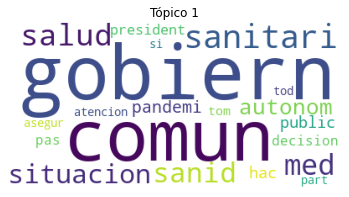

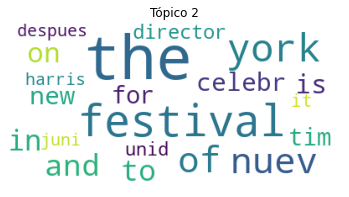

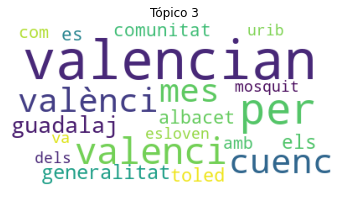

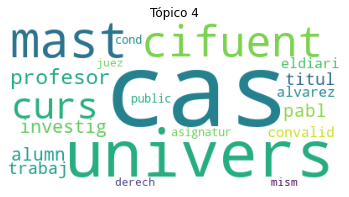

In [35]:
for i in range(1, 5):
    plt.figure()
    plt.imshow(WordCloud(background_color='white', prefer_horizontal=1.0)
               .fit_words(dict(lda.show_topic(i, 20))))
    plt.axis("off")
    plt.title("Tópico " + str(i))
    plt.show()

## Evaluación del modelo

Para evaluar el rendimiento del modelo, estimaremos los tópicos en dos documentos diferentes. En el primer caso, escogeremos un documento de entre las noticias utilizadas en el corpus para entrenar el modelo y para la segunda prueba utilizaremos una nueva noticia.

Así, empezamos escogiendo una noticia del corpus al azar y mostramos su contenido y titular.

In [36]:
indice_noticia = random.randint(0,len(df))
noticia = df.iloc[indice_noticia]
print("Titular: " + noticia.Titular)
print(noticia.Noticia)

Titular: Carrizosa (Cs) a Torra: "Trabajemos juntos y dejen los cuentos de siempre"
En un apunte en Twitter recogido por Europa Press, Carrizosa ha respondido a la crítica de Torra sobre que el Gobierno "confisque" competencias de la Generalitat en el marco del estado de alarma por el coronavirus.                  "Algunos se empeñan en poner las cosas difíciles. No importa quién ejerce las competencias para salvar vidas, sino trabajar bien y salvarlas", ha afirmado Carrizosa, que ha añadido que ya habrá tiempo para valorar cómo afrontó la crisis del coronavirus cada gobierno.            Etiquetas    /   Política


In [37]:
bow_noticia = corpus[indice_noticia]
distribucion_noticia = lda[bow_noticia]

In [38]:
# Después, sacamos los índices y la contribución (proporción) de los tópicos más significativos para nuestra noticia 
# y los mostramos en un gráfico de barras para un mejor entendimiento.

# Indices de los topicos mas significativos
dist_indices = [topico[0] for topico in lda[bow_noticia]]

# Contribución de los topicos mas significativos
dist_contrib = [topico[1] for topico in lda[bow_noticia]]

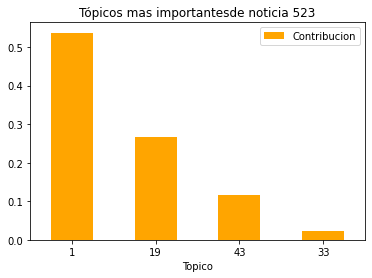

In [39]:
distribucion_topicos = pd.DataFrame({'Topico':dist_indices,
                                     'Contribucion':dist_contrib })
distribucion_topicos.sort_values('Contribucion', 
                                 ascending=False, inplace=True)
ax = distribucion_topicos.plot.bar(y='Contribucion',x='Topico', 
                                   rot=0, color="orange",
                                   title = 'Tópicos mas importantes'
                                   'de noticia ' + str(indice_noticia))

In [40]:
# El tópico más predominante en la noticia es el 1, seguido de los tópicos 19 y 43. Seguidamente, imprimimos las palabras más significativas de estos.

for ind, topico in distribucion_topicos.iterrows():
    print("*** Tópico: " + str(int(topico.Topico)) + " ***")
    palabras = [palabra[0] for palabra in lda.show_topic(
        topicid=int(topico.Topico))]
    palabras = ', '.join(palabras)
    print(palabras, "\n")

*** Tópico: 1 ***
gobiern, comun, sanitari, salud, med, sanid, situacion, autonom, pandemi, public 

*** Tópico: 19 ***
hac, si, pued, cre, ser, pod, sol, habl, cos, pas 

*** Tópico: 43 ***
pp, gobiern, part, polit, ciudadan, pod, sanchez, pso, cas, president 

*** Tópico: 33 ***
twitt, red, vide, polic, agent, protest, mensaj, manifest, trump, com 



Para la segunda prueba, asignaremos los tópicos a un nuevo documento no utilizado en el entrenamiento del modelo LDA. La noticia escogida trata sobre la violencia de género en Cantabria.

Antes de nada abrimos la noticia que esta en formato texto.

In [41]:
from google.colab import files
uploaded = files.upload()

Saving noticia1.txt to noticia1.txt


In [42]:
texto_articulo = open("noticia1.txt")
articulo_nuevo = texto_articulo.read().replace("\n", " ")
texto_articulo.close()

In [43]:
articulo_nuevo = limpiar_texto(articulo_nuevo)
articulo_nuevo = tokenizer.tokenize(articulo_nuevo)
articulo_nuevo = filtrar_stopword_digitos(articulo_nuevo)
articulo_nuevo = stem_palabras(articulo_nuevo)
articulo_nuevo

['cantabri',
 'viv',
 'año',
 'negr',
 'refier',
 'violenci',
 'gener',
 'doc',
 'mes',
 'comun',
 'acumul',
 'total',
 'denunci',
 'mujer',
 'victim',
 'violenci',
 'machist',
 'año',
 'sald',
 'dos',
 'asesin',
 'man',
 'parej',
 'unas',
 'cifr',
 'sobrecog',
 'marc',
 'hoj',
 'rut',
 'segun',
 'reconoc',
 'viern',
 'portavoz',
 'gobiern',
 'autonom',
 'pabl',
 'zuloag',
 'present',
 'memori',
 'anual',
 'mal',
 'dat',
 'par',
 'ahi',
 'inform',
 'recog',
 'numer',
 'denunci',
 'present',
 'cantabri',
 'año',
 'pas',
 'supon',
 'cifr',
 'alta',
 'registr',
 'ahor',
 'dict',
 'total',
 'orden',
 'alej',
 'acus',
 'conden',
 'firm',
 'tribunal',
 'registr',
 'avergüenz',
 'socied',
 'expres',
 'vicepresident',
 'cantabri',
 'present',
 'segun',
 'memori',
 'centr',
 'inform',
 'atencion',
 'integral',
 'gobiern',
 'cantabri',
 'asesor',
 'mujer',
 'acud',
 'primer',
 'vez',
 'are',
 'mal',
 'trat',
 'mujer',
 'asist',
 'menor',
 'total',
 'person',
 'ingres',
 'centr',
 'emergent',
 'c

In [47]:
bow_articulo_nuevo = diccionario.doc2bow(articulo_nuevo)

In [48]:
# Una vez tenemos la representación BOW, solo nos queda mostrar los resultados
# Indices de los topicos mas significativos
dist_indices = [topico[0] for topico in lda[bow_articulo_nuevo]]
# Contribucion de los topicos mas significativos
dist_contrib = [topico[1] for topico in lda[bow_articulo_nuevo]]

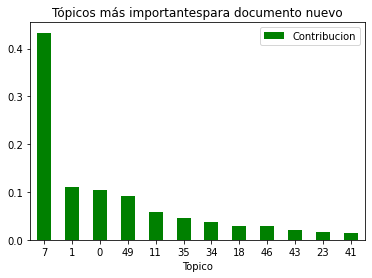

In [49]:
distribucion_topicos = pd.DataFrame({'Topico':dist_indices,
                                     'Contribucion':dist_contrib })
distribucion_topicos.sort_values('Contribucion', 
                                 ascending=False, inplace=True)
ax = distribucion_topicos.plot.bar(y='Contribucion',x='Topico', 
                                   rot=0, color="green",
                                   title = 'Tópicos más importantes' 
                                   'para documento nuevo')

El tópico 7 es el más significante con diferencia en la noticia. Imprimimos de nuevo las palabras más significativas

In [50]:
for ind, topico in distribucion_topicos.iterrows():
    print("*** Tópico: " + str(int(topico.Topico)) + " ***")
    palabras = [palabra[0] for palabra in lda.show_topic(
        topicid=int(topico.Topico))]
    palabras = ', '.join(palabras)
    print(palabras, "\n")

*** Tópico: 7 ***
mujer, sexual, violenci, gener, hombr, muj, person, femin, victim, iguald 

*** Tópico: 1 ***
gobiern, comun, sanitari, salud, med, sanid, situacion, autonom, pandemi, public 

*** Tópico: 0 ***
cas, resident, posit, person, centr, fallec, dat, ultim, cov, coronavirus 

*** Tópico: 49 ***
tribunal, judicial, fiscal, justici, derech, suprem, delit, sentenci, ley, cas 

*** Tópico: 11 ***
años, cas, pas, dos, hac, dia, llev, sal, trabaj, lleg 

*** Tópico: 35 ***
proyect, agu, desarroll, medi, cambi, form, zon, climat, ciud, ecolog 

*** Tópico: 34 ***
cantabri, santand, cantabr, miguel, mar, salmeron, torrelaveg, ceip, menendez, altamir 

*** Tópico: 18 ***
contrat, eur, empres, montai, adjud, grup, concurs, public, trabaj, factur 

*** Tópico: 46 ***
histori, libr, pelicul, cin, años, vid, mund, personaj, obra, autor 

*** Tópico: 43 ***
pp, gobiern, part, polit, ciudadan, pod, sanchez, pso, cas, president 

*** Tópico: 23 ***
canari, navarr, barcelon, foral, palm, ap

Finalmente guardamos el modelo y el diccionario para utilizarlo más adelante. Para ello usamos la función save() en ambos casos.

In [51]:
lda.save("articulos.model")
diccionario.save("articulos.dictionary")

## Usando la métrica Jensen Shannon para calcular la distancia entre textos

Una de estas técnicas consiste en representar los textos como bolsas de palabras (BOW) y aplicar la similitud de coseno para comparar la similitud entre dos documentos. En este caso, la semejanza entre los dos textos dependerá del número de palabras que compartan.

Hay varios problemas evidentes con este tipo de técnicas. Por ejemplo, una palabra puede tener varios significados completamente diferentes y, al carecer de contexto estos métodos, no pueden saber a que significado se refiere. Además, es posible que dos frases que no compartan ninguna palabra tengan un significado muy similar, como, por ejemplo: “Fui en coche a su casa y compramos algo para comer” y “El otro día conduje hacia su piso y pedimos unas hamburguesas». Mirando solamente las palabras de las frases anteriores, concluiríamos que esas frases no tienen nada que ver. Sin embargo, las dos frases tienen un alto grado de similitud y el modelo que utilizamos debería ser capaz de detectarlo.

Por ello, es importante que los modelos tengan también en cuenta la similitud semántica, es decir, que puedan entender el significado real de las palabras o de la frase en cada contexto. Existen varios métodos para extraer esta similitud semántica de los textos, como los ampliamente utilizados modelos de word embeddings que permiten representar cada palabra como un vector de números reales y capturar de esta forma su información semántica.

El procedimiento a seguir es sencillo. Primero obtenemos la distribución de tópicos del texto nuevo del cual queremos obtener los textos más similares. Después, solo nos queda calcular la distancia entre ese texto nuevo y el resto comparando sus distribuciones de tópicos.

Para calcular la distancia entre dos distribuciones utilizaremos la métrica de distancia de Jensen-Shannon, una medida de distancia estadística entre distribuciones de probabilidad. Esta métrica nos devolverá un valor comprendido entre 0 y 1, donde cuanto menor sea este valor significa una mayor similitud entre las dos distribuciones.

In [52]:
from gensim.matutils import jensen_shannon

In [53]:
# Después, le aplicamos el modelo LDA a una nueva noticia para obtener su distribución de tópicos con las proporciones de pertenencia de cada tópico en el documento.
# Para la obtención de los tópicos debemos realizar el preprocesamiento al texto de la noticia y obtener su representación BOW. 

texto_articulo = open("noticia1.txt")
articulo_nuevo = texto_articulo.read().replace("\\n", " ")
texto_articulo.close()

In [54]:
articulo_nuevo = limpiar_texto(articulo_nuevo)
articulo_nuevo = tokenizer.tokenize(articulo_nuevo)
articulo_nuevo = filtrar_stopword_digitos(articulo_nuevo)
articulo_nuevo = stem_palabras(articulo_nuevo)

In [55]:
bow_articulo_nuevo = diccionario.doc2bow(articulo_nuevo)

Con el método get_document_topics de Gensim obtenemos la distribución de tópicos y ajustando el parámetro minimum_probability a 0 nos aseguraremos de que ningún tópico sea descartado.

In [56]:
distribucion_noticia = lda.get_document_topics(bow_articulo_nuevo, 
                                               minimum_probability=0)

Esa será la distribución que necesitamos para comparar las noticias. Seguidamente creamos un método que se encarga de calcular la distancia entre dos distribuciones. De nuevo gensim nos facilitará el trabajo al contar con la función jensen_shannon que hará este cálculo por nosotros.

In [57]:
def calcular_jensen_shannon_sim_doc_doc(doc_dist1, doc_dist2):
    """Calcula la distancia Jensen Shannon entre dos documentos.
    """
    return jensen_shannon(doc_dist1, doc_dist2)

También implementamos un método que se encarga de calcular las distancias entre las distribuciones de tópicos de nuestra noticia con las del resto y mostrar el titular de aquellas más similares, es decir, las que tengan la distancia más baja, junto con el valor de esta.

In [58]:
def mostrar_n_mas_similares(distribucion_noticia, n):
    """Muestra las n noticias mas similares a partir 
       de una distribucion de tópicos.
    """
    distancias = [calcular_jensen_shannon_sim_doc_doc(
        distribucion_noticia, lda[noticia]) for noticia in corpus]
    mas_similares = np.argsort(distancias)
    for i in range(0,n):
        titular = df.iloc[int(mas_similares[i])].Titular
        print(f'{i + 1}: {titular} ({distancias[mas_similares[i]]})')

Ahora simplemente usamos el método implementado pasándole como entrada la distribución de nuestra noticia y el número de noticias más similares que queremos mostrar.

In [59]:
mostrar_n_mas_similares(distribucion_noticia, 10)

1: El año arranca con el reto de reconocer la violencia machista fuera de la pareja tras los 47 asesinatos contabilizados en 2018 (0.1377231627702713)
2: La violencia machista deja mil mujeres asesinadas por hombres en los últimos dieciséis años (0.14652910828590393)
3: La atención sanitaria a las personas trans en Catalunya dejará de estar basada en un diagnóstico psiquiátrico (0.17757654190063477)
4: Obligan a una niña argentina de 11 años violada a someterse a una cesárea en lugar de un aborto (0.17987649142742157)
5: El Parlamento de Navarra solicita por unanimidad medios para esclarecer los casos de abusos en la Iglesia (0.1818767637014389)
6: Aumentan significativamente las denuncias de abuso sexual a menores en Panamá (0.1858239769935608)
7: El Gobierno central homenajea a una víctima de maltrato que lleva más de un año esperando un indulto (0.18650855123996735)
8: La Fiscalía no probó ninguna denuncia falsa por violencia de género el año pasado (0.18988889455795288)
9: España s